In [157]:
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import f1_score, classification_report


In [158]:
import pandas as pd

train = pd.read_csv(
    r'C:\Users\moad1\Desktop\Data S challenge Imperial\msc_statistics_data_science_challenge\data\transactions_training_sept_oct_2023_afternoon.csv',
    sep=";",               # séparateur de colonnes
    decimal=",",           # virgule comme séparateur décimal
    na_values="NA",        # valeur manquante
    parse_dates=["DATETIME_GMT"]  # convertir la colonne date
)


In [159]:
import pandas as pd

test_original = pd.read_csv(
    r'C:\Users\moad1\Desktop\Data S challenge Imperial\msc_statistics_data_science_challenge\data\transactions_unclassified_2023_afternoon.csv',
    sep=";",               # séparateur de colonnes
    decimal=",",           # virgule comme séparateur décimal
    na_values="NA",        # valeur manquante
    parse_dates=["DATETIME_GMT"]  # convertir la colonne date
)


In [160]:
test = pd.read_csv(
    r'C:\Users\moad1\Desktop\Data S challenge Imperial\msc_statistics_data_science_challenge\data\transactions_unclassified_2023_afternoon.csv',
    sep=";",               # séparateur de colonnes
    decimal=",",           # virgule comme séparateur décimal
    na_values="NA",        # valeur manquante
    parse_dates=["DATETIME_GMT"]  # convertir la colonne date
)

In [161]:
sorted_df = train.sort_values("DATETIME_GMT").reset_index(drop=True)

# Taille du split (20% en test)
split_idx = int(len(sorted_df) * 0.8)

# Séparation manuelle
train_df = sorted_df.iloc[:split_idx]
test_df  = sorted_df.iloc[split_idx:]

# Séparation X / y
X_train = train_df.drop(columns=["FLAG_FRAUD"])
y_train = train_df["FLAG_FRAUD"].astype(int)

X_test = test_df.drop(columns=["FLAG_FRAUD"])
y_test = test_df["FLAG_FRAUD"].astype(int)

In [ ]:
def enrich_features(df):
    df = df.copy()
    
    # Nettoyage de base
    df["ID_CARD"] = pd.to_numeric(df["ID_CARD"], errors="coerce")
    df["DATETIME_GMT"] = pd.to_datetime(df["DATETIME_GMT"])
    df["hour"] = df["DATETIME_GMT"].dt.hour
    df["hour_wave"] = df["hour"].apply(lambda h: h if h <= 11 else 23 - h)
    df.drop(columns=["hour"])
    df["day_of_week"] = df["DATETIME_GMT"].dt.dayofweek

    # Calcul des features temporelles sur une copie triée
    df_sorted = df.sort_values(by=["ID_CARD", "DATETIME_GMT"]).copy()
    df_sorted["time_since_last_txn"] = df_sorted.groupby("ID_CARD")["DATETIME_GMT"].diff().dt.total_seconds()
    df_sorted["amount_diff_since_last_txn"] = df_sorted.groupby("ID_CARD")["AMOUNT"].diff()
    
    # Alignement dans l'ordre original
    df = df.merge(
        df_sorted[["ID_TRX", "time_since_last_txn", "amount_diff_since_last_txn"]],
        on="ID_TRX",
        how="left"
    )

    # Ajout de variables simples
    df["is_night"] = df["hour"].apply(lambda h: 1 if h < 6 or h >= 22 else 0)
    df["trx_count_card"] = df.groupby("ID_CARD").cumcount() + 1

    # Recalcul de la rolling mean sur une version triée, puis réalignement
    df_sorted["rolling_mean_amt_card5"] = (
        df_sorted.groupby("ID_CARD")["AMOUNT"]
                 .transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    )
    
    df = df.merge(
        df_sorted[["ID_TRX", "rolling_mean_amt_card5"]],
        on="ID_TRX",
        how="left"
    )

    # Agrégation des anomalies population
    pop_anoms = [col for col in df.columns if "Population_Anomaly_" in col]
    df["pop_anom_sum"] = df[pop_anoms].sum(axis=1)
    
    df['amout_zcore_card'] = df.groupby('ID_CARD')

    return df


In [163]:
X_train = enrich_features(X_train)
X_test = enrich_features(X_test)


In [164]:
X_train = X_train.drop(columns=["hour"])
X_test = X_test.drop(columns=["hour"])


In [165]:
X_train = X_train.drop(columns=["DATETIME_GMT"])
X_test = X_test.drop(columns=["DATETIME_GMT"])


In [166]:
X_train = X_train.drop(columns=["ID_TRX"])
X_test = X_test.drop(columns=["ID_TRX"])


Feature eng


In [167]:
weight = (y_train == 0).sum() / (y_train == 1).sum()

In [174]:

# 3. Modèle XGBoost
model = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",  # évite warning
    n_estimators=1500,
    max_depth=6,
    learning_rate=0.03,
    scale_pos_weight=weight,
    subsample = 0.8,
    colsample_bytree = 0.6,
    #reg_alpha = 0.5,
    random_state=8
)

# 4. Entraînement
model.fit(X_train, y_train)

# 5. Prédictions (avec seuil par défaut = 0.5)
y_pred = model.predict(X_test)

# 6. Évaluation
print(classification_report(y_test, y_pred, digits=4))
print("F1-score:", f1_score(y_test, y_pred))


y_train_pred = model.predict(X_train)

# Évaluation sur train
print("\n=== Performance sur le train set ===")
print(classification_report(y_train, y_train_pred, digits=4))
print("F1-score (train) :", f1_score(y_train, y_train_pred))




c:\Users\moad1\Desktop\Data S challenge Imperial\msc_statistics_data_science_challenge\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:24:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     15972
           1     0.8889    0.8571    0.8727        28

    accuracy                         0.9996     16000
   macro avg     0.9443    0.9285    0.9363     16000
weighted avg     0.9996    0.9996    0.9996     16000

F1-score: 0.8727272727272727

=== Performance sur le train set ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     63936
           1     0.9846    1.0000    0.9922        64

    accuracy                         1.0000     64000
   macro avg     0.9923    1.0000    0.9961     64000
weighted avg     1.0000    1.0000    1.0000     64000

F1-score (train) : 0.9922480620155039


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

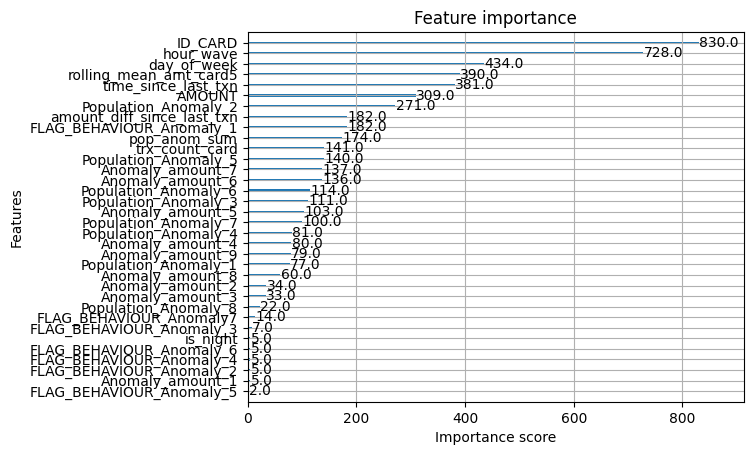

In [150]:
plot_importance(model)

In [151]:
# 3. Modèle XGBoost
model = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",  # évite warning
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01 ,
    scale_pos_weight=weight,
    random_state=4
)

# 4. Entraînement
model.fit(X_train, y_train)

# 5. Prédictions (avec seuil par défaut = 0.5)
y_pred = model.predict(X_test)

# 6. Évaluation
print(classification_report(y_test, y_pred, digits=4))
print("F1-score:", f1_score(y_test, y_pred))


y_train_pred = model.predict(X_train)

# Évaluation sur train
print("\n=== Performance sur le train set ===")
print(classification_report(y_train, y_train_pred, digits=4))
print("F1-score (train) :", f1_score(y_train, y_train_pred))




c:\Users\moad1\Desktop\Data S challenge Imperial\msc_statistics_data_science_challenge\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:23:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0     0.9997    0.9992    0.9995     15972
           1     0.6486    0.8571    0.7385        28

    accuracy                         0.9989     16000
   macro avg     0.8242    0.9282    0.8690     16000
weighted avg     0.9991    0.9989    0.9990     16000

F1-score: 0.7384615384615385

=== Performance sur le train set ===
              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000     63936
           1     0.9143    1.0000    0.9552        64

    accuracy                         0.9999     64000
   macro avg     0.9571    1.0000    0.9776     64000
weighted avg     0.9999    0.9999    0.9999     64000

F1-score (train) : 0.9552238805970149


In [152]:
X_train = train.drop(columns=["FLAG_FRAUD", "DATETIME_GMT"])
y_train = train["FLAG_FRAUD"].astype(int)

In [153]:
X_test = test.drop(columns=["DATETIME_GMT"])  # ou garde-la si tu l’as encodée


In [154]:
weight = (y_train == 0).sum() / (y_train == 1).sum()

In [155]:
from xgboost import XGBClassifier

final_model = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",  # évite warning
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01 ,
    scale_pos_weight=weight,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_alpha = 0.1,
    random_state=8
)

final_model.fit(X_train, y_train)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:ID_CARD: object

In [ ]:
y_train_pred = final_model.predict(X_train)
print("\n=== Performance sur le TRAIN set ===")
print(classification_report(y_train, y_train_pred, digits=4))
print("F1-score (train) :", f1_score(y_train, y_train_pred))

# 6. Prédictions sur le test final (avec seuil par défaut = 0.5)
y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > 0.5).astype(int)





=== Performance sur le TRAIN set ===
              precision    recall  f1-score   support

           0     1.0000    0.9999    0.9999     79908
           1     0.9020    1.0000    0.9485        92

    accuracy                         0.9999     80000
   macro avg     0.9510    0.9999    0.9742     80000
weighted avg     0.9999    0.9999    0.9999     80000

F1-score (train) : 0.9484536082474226


In [ ]:
X_test

,ID_TRX,ID_CARD,AMOUNT,Anomaly_amount_1,Anomaly_amount_2,Anomaly_amount_3,Anomaly_amount_4,Anomaly_amount_5,Anomaly_amount_6,Anomaly_amount_7,...,Population_Anomaly_4,Population_Anomaly_5,Population_Anomaly_6,Population_Anomaly_7,Population_Anomaly_8,time_since_last_txn,amount_diff_since_last_txn,hour,dayofweek,is_night
7369,200869990,17467387,15.0,-0.500000,1.895238,2.841026,3.170370,4.109333,-5.213636,12.333333,...,7.254217,6.763287,6.837152,8.222222,4.733333,NaN,NaN,13,4,0
7026,200853531,18018649,58.0,-1.000000,0.206897,0.206897,0.206897,-0.181034,0.181034,-1.000000,...,1.134711,1.007747,1.026850,0.022989,-1.000000,NaN,NaN,10,4,0
8826,200948220,18489176,80.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,...,0.005232,0.010413,0.015824,-1.000000,-1.000000,NaN,NaN,2,5,1
5703,200783343,18780243,99.0,0.555556,-0.208081,0.085859,-0.176136,-0.254930,0.344799,-0.555556,...,0.250639,0.176256,0.187447,0.000000,-0.329293,NaN,NaN,5,4,1
8845,200949029,18780243,130.0,0.184615,-0.396923,-0.173077,-0.372596,-0.432601,0.494130,-0.450000,...,-0.047590,-0.104236,-0.095713,-0.300000,-0.310769,85260.0,31.0,4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9935,201007342,62284787,140.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,...,-0.094375,-0.126493,-0.125012,-1.000000,-1.000000,NaN,NaN,10,5,0
10352,201031175,62286115,18.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,...,20.935010,20.792215,21.127550,-1.000000,-1.000000,NaN,NaN,13,5,0
10816,201055818,62287920,100.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,...,2.948302,2.922599,2.982959,-1.000000,-1.000000,NaN,NaN,15,5,0
10335,201029989,62288833,25.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,...,4.374574,4.232319,4.233252,-1.000000,-1.000000,NaN,NaN,13,5,0


In [ ]:
y_test_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(11557,))

In [ ]:
df_submit = pd.DataFrame({
    'FLAG_FRAUD' : y_test_pred
})

In [ ]:
df_submit.to_csv('CrankThatBayH.csv')

In [ ]:
df_result_wtih_ID = pd.DataFrame({
    'ID_TRX': X_test['ID_TRX'].values,
    'FLAG_FRAUD': y_test_pred
})


In [ ]:
test_original

,ID_TRX,ID_CARD,DATETIME_GMT,AMOUNT,Anomaly_amount_1,Anomaly_amount_2,Anomaly_amount_3,Anomaly_amount_4,Anomaly_amount_5,Anomaly_amount_6,...,FLAG_BEHAVIOUR_Anomaly_8,Anomaly_amount_9,Population_Anomaly_1,Population_Anomaly_2,Population_Anomaly_3,Population_Anomaly_4,Population_Anomaly_5,Population_Anomaly_6,Population_Anomaly_7,Population_Anomaly_8
1,200492121,30486544,2023-10-17 11:35:00,350.0,-0.285714,-0.410714,-0.464286,-0.459184,-0.407143,0.403061,...,0,1.205674,-1.000000,-0.644880,-0.628587,-0.637750,-0.650597,-0.650005,-0.190476,-0.328571
2,200492138,51204390,2023-10-17 11:35:00,33.0,0.323232,1.359307,1.359307,0.979798,0.903030,-0.573803,...,0,0.938124,0.573803,2.766422,2.939225,2.842045,2.705788,2.712072,-0.050505,0.012121
3,200492221,60321087,2023-10-17 11:36:00,300.0,-1.000000,2.333333,2.333333,2.333333,2.333333,-2.329983,...,0,NaN,-1.000000,0.254489,0.330933,0.316101,0.307533,0.327653,-1.000000,-1.000000
4,200492248,32008209,2023-10-17 11:36:00,50.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,0,NaN,-1.000000,1.485838,1.599888,1.535750,1.445820,1.449967,-1.000000,-1.000000
5,200492256,37927102,2023-10-17 11:36:00,56.6,2.922261,2.922261,2.922261,0.305212,0.383324,-0.454653,...,0,1.240983,-1.000000,1.195970,1.296721,1.240061,1.160619,1.164282,1.097173,0.689929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11553,201093781,50558333,2023-10-21 21:40:00,95.0,-0.821053,-0.809747,-0.806040,-0.805263,-0.780886,0.779863,...,0,0.953453,-0.770175,0.365989,0.444396,0.414362,0.376926,0.377172,-0.554386,-0.532632
11554,201093809,31868862,2023-10-21 21:47:00,360.0,-1.000000,-1.000000,-0.541667,-0.589236,-0.604012,0.623291,...,0,1.161616,-1.000000,-0.629559,-0.601079,-0.612934,-0.627143,-0.627191,-0.361111,-0.450000
11555,201093877,49895393,2023-10-21 22:21:00,52.0,-1.000000,0.544872,0.072115,0.071006,0.165992,-0.397436,...,0,1.168317,0.392573,1.390229,1.499893,1.438221,1.351750,1.355738,1.269231,0.942308
11556,201093880,52073476,2023-10-21 22:21:00,29.0,-0.536050,0.009828,-0.261835,-0.265681,-0.230279,0.219606,...,0,0.971014,0.274877,3.474790,3.731644,3.633253,3.510620,3.511424,-0.229885,-0.206897


In [ ]:
df_result_wtih_ID

,ID_TRX,FLAG_FRAUD
0,200869990,0
1,200853531,0
2,200948220,0
3,200783343,0
4,200949029,0
...,...,...
11552,201007342,0
11553,201031175,0
11554,201055818,0
11555,201029989,0


In [ ]:
df_result_sorted = df_result_wtih_ID.set_index('ID_TRX').loc[test_original['ID_TRX']].reset_index()


In [ ]:
df_result_sorted['FLAG_FRAUD']

0        0
1        0
2        0
3        0
4        0
        ..
11552    0
11553    0
11554    0
11555    0
11556    0
Name: FLAG_FRAUD, Length: 11557, dtype: int64

In [ ]:
df_result_sorted['FLAG_FRAUD'].to_csv('CrankThatBayH_sorted_correctly_1.csv')

In [ ]:
df_submit['FLAG_FRAUD'].sum()/len(df_submit['FLAG_FRAUD'])

np.float64(0.0028554123042312017)

In [ ]:
y_train.mean()

np.float64(0.00115)